<h1><center>TDA and Statistics using Gudhi Python Library </center></h1>

<h1><center>Part 3 - Bootstrap and Subsampling Procedures </center></h1>


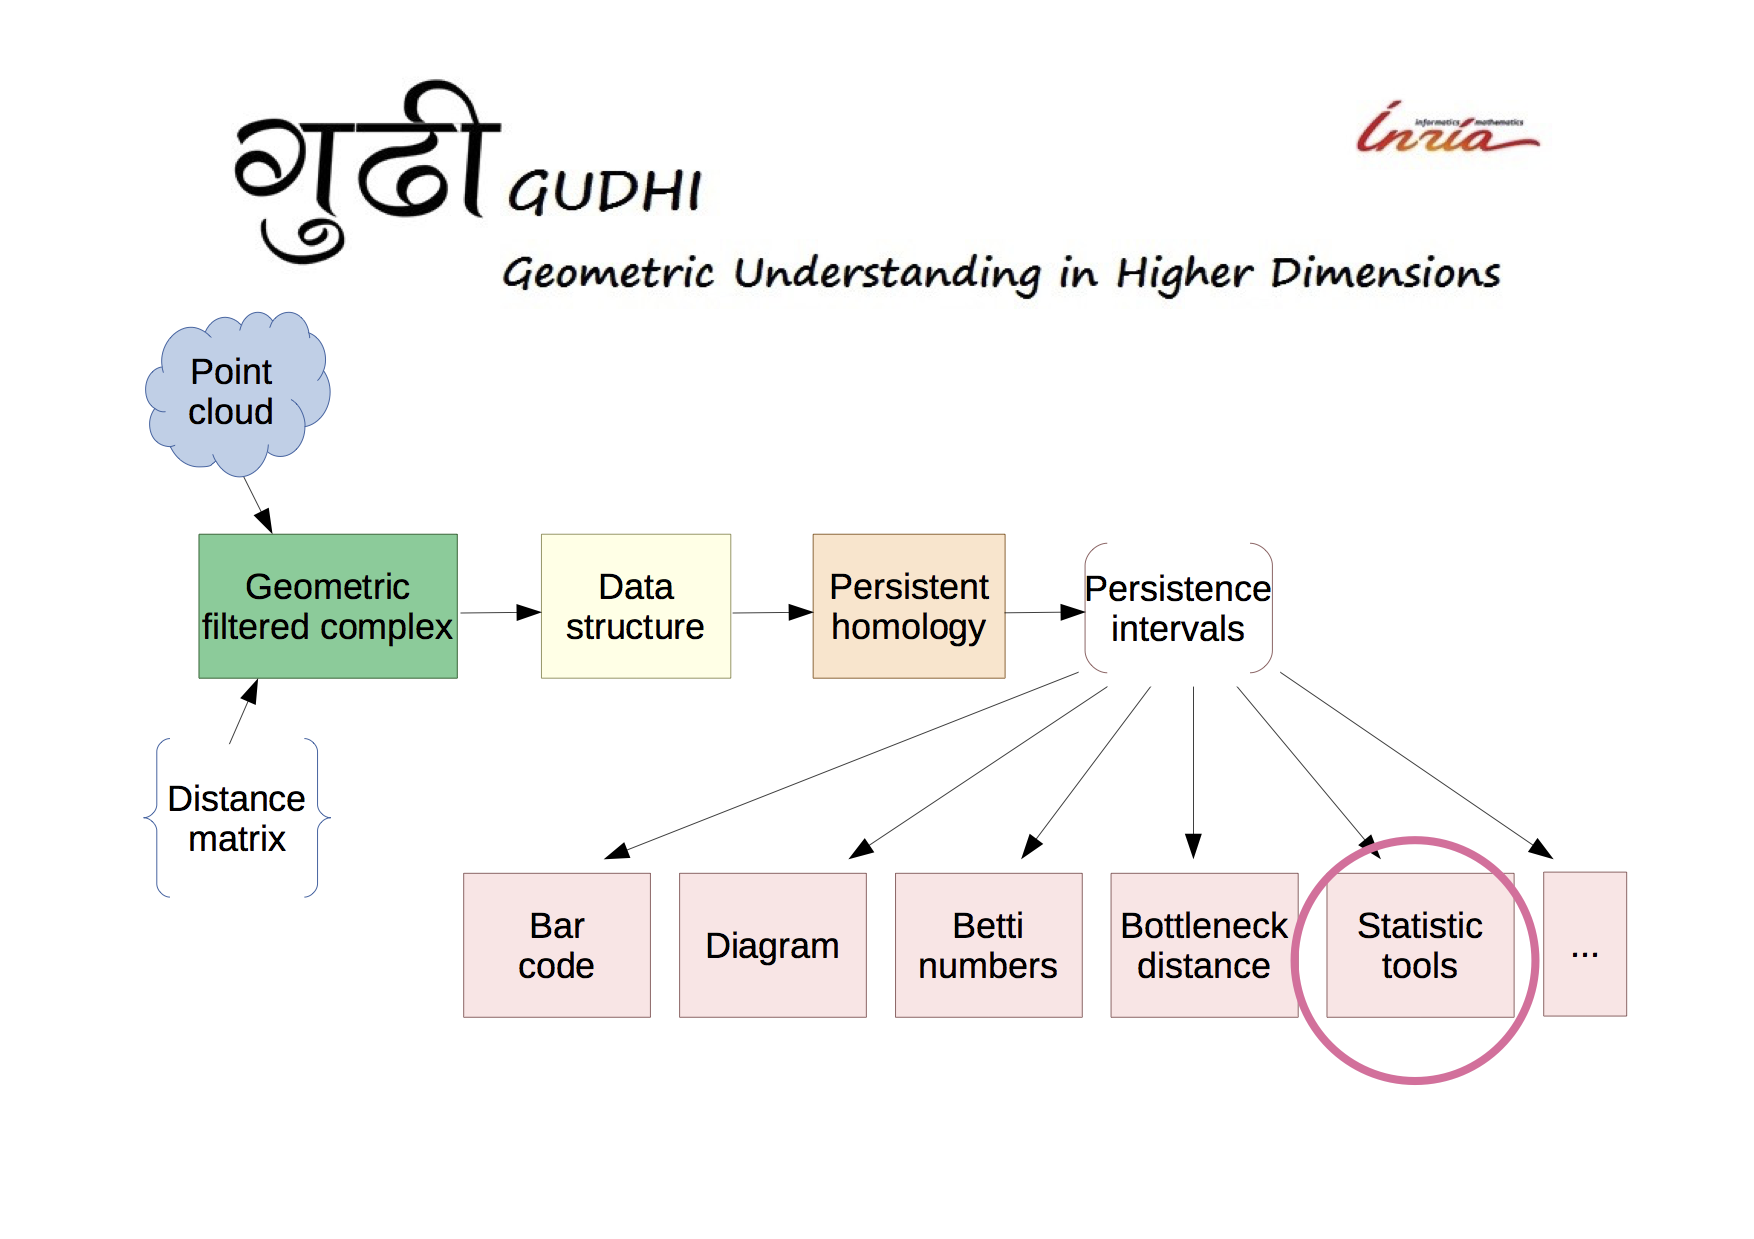

In [1]:
from IPython.display import Image
Image("SlidesGudhi/GeneralPipeLine_Boot.png")

In this third part of the tutorial we introduce bootstrap procedures for peristence homology. We start with the case of confidence regions for persistence homology of filtrations of simplicial complexes directly defined on point clouds. 

In [ ]:
import numpy as np
import pandas as pd
import pickle as pickle
import gudhi as gd
from pylab import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KDTree
from sklearn.neighbors.kde import KernelDensity
import ipyparallel as ipp
%matplotlib inline

We will need additional functionalities for ploting confidence regions for persistence homology (coming in the next releases of Gudhi).

Download the python file [persistence_graphical_tools_Bertrand.py](http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/persistence_graphical_tools_Bertrand.py) and save it in your working repository (or in your python path).

In [ ]:
from persistence_graphical_tools_Bertrand import *

We illustrate the bootstrap procedure for the crater dataset with a filtration of alpha Complexes.

In [ ]:
f = open("crater_tuto","rb")
crater = pickle.load(f)
f.close()

In [ ]:
plt.scatter(crater[:,0],crater[:,1],s=0.1)

In [ ]:
sns.kdeplot(crater, shade = True, cmap = "PuBu",bw=.3)

We define a filtration of alpha Complexes (it takes a few seconds)

In [ ]:
Alpha_complex_crater = gd.AlphaComplex(points = crater)
Alpha_simplex_tree_crater = Alpha_complex_crater.create_simplex_tree(max_alpha_square=2) 
diag_crater = Alpha_simplex_tree_crater.persistence()

### Removing points close to the diagonal

For many applications of persistent homology, we observe many topological features closed to the diagonal. 

Since they correspond to topological structures that die very soon after they appear in the filtration, these points are generally considered as noise. We will see that confidence regions for persistence diagram provide a rigorous framwork to this idea.

<p style="border:2px; border-style:solid; padding: 0.5em;border-color:red"> 
<b> Exercice. </b> Give the number of persistence intervals per dimension in the filtration.
 </p>

Representing in the diagram all the topological features is not relevant since most of them have very short persistence. Moreover, ploting all the points takes too much time. We want to select only the more persistent features of the filtration.

<p style="border:2px; border-style:solid; padding: 0.5em;border-color:red"> 
<b> Exercice. </b>   For some given value k, compute the truncated persistence version of the Alpha Complex filtration by keeping only the k highest persistence intervals per dimension.
 </p>

### Confidence regions for persistent homology

Confidence regions for persistence diagram provide a rigorous framework for selecting significant topological features in a persistence diagram.

We use the bottleneck distance $d_b$ to define confidence regions.

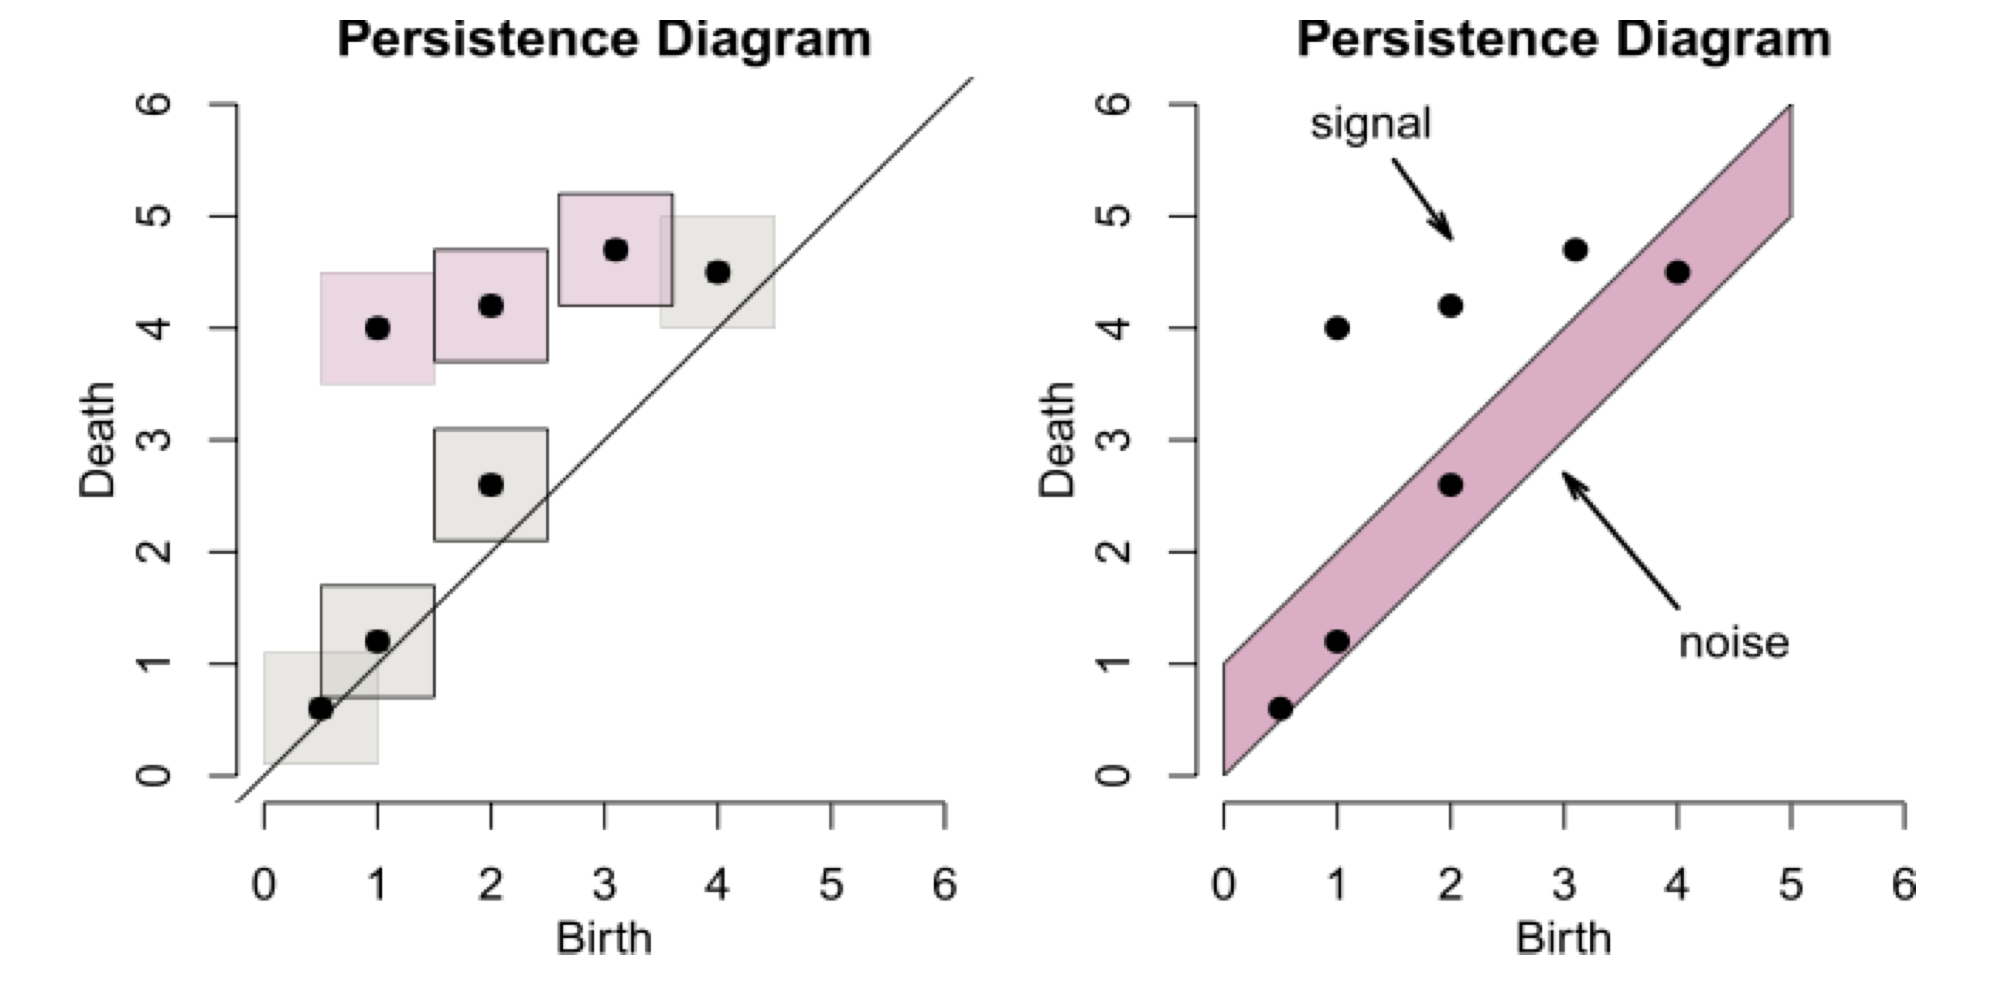

In [2]:
Image("SlidesGudhi/ConfRegions.png",width=600)

<center> [From [Fasy etal. 2014 AoS](https://arxiv.org/pdf/1303.7117.pdf)] </center>

We see point clouds as random variables. Under this approach, persistence diagrams are also considered as random quantities:

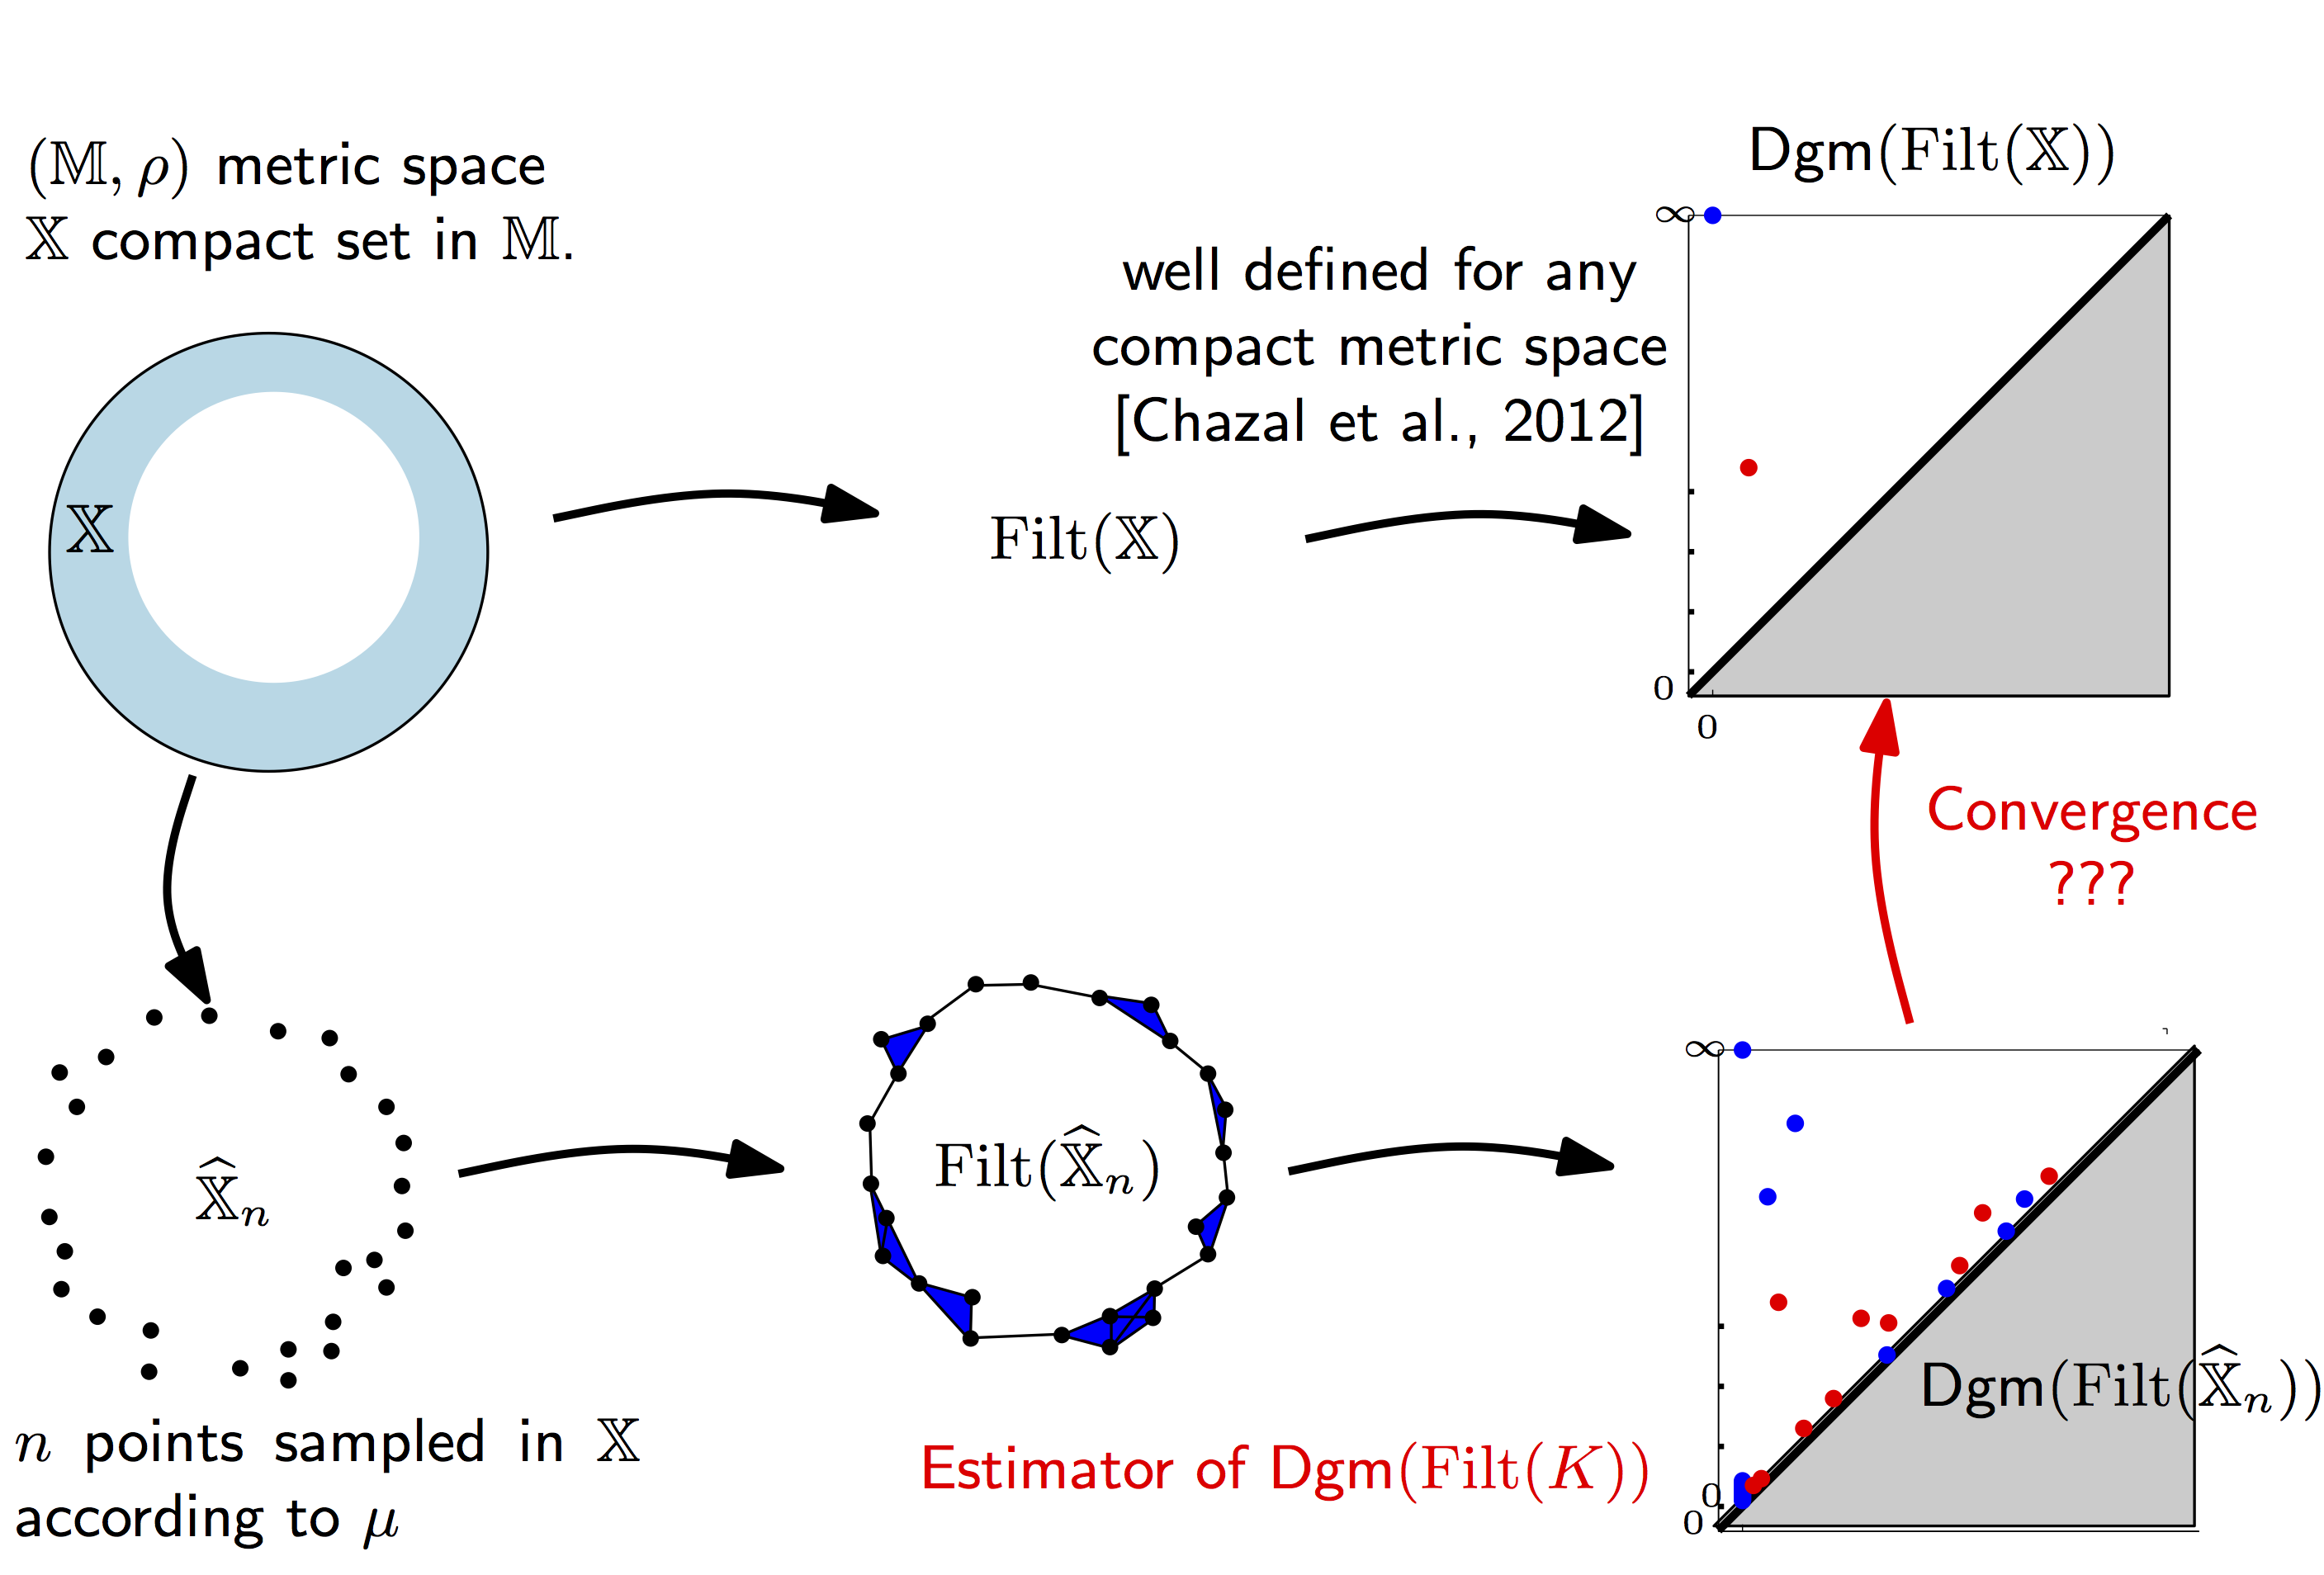

In [3]:
Image("SlidesGudhi/GeneralSetting.png",width=800)

Defining confidence regions for persistence diagrams requires to evaluate the "variance" of persistence diagrams.

Bootstrap and subsampling are general methods for estimating variance terms.

+ $P$ : underlying probability measure for the point cloud   
+ $P_n$ : empirical measure    
+ $P_n^*$ : subsample or bootstrap measure    

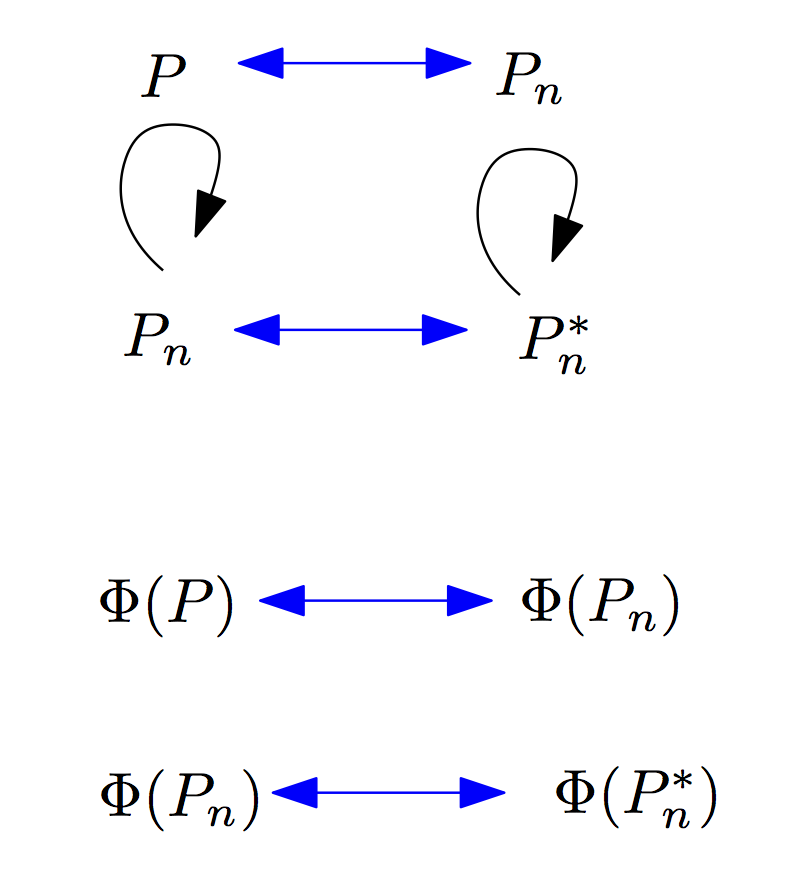

In [4]:
Image("SlidesGudhi/Bootstrap.png",width=300)

### Subsampling approach

With this method, confidence regions for persistence diagram are derived from a confidence regions in Hausdorff distance for the support $\mathbb X$ of the distribution of the sample.

Indeed, according the stability of persistence diagrams:

   $$
P \left( d_b\left( Dgm \left(  Filt(\mathbb X) \right)  ,  Dgm \left(  Filt(\mathbb X_n) \right)  \right)  >
\hat \eta_\alpha   \right)
 \leq  
 P  \bigl( Hauss \left(\mathbb X, \mathbb X _{n} \right)  > \hat \eta_\alpha \bigr)
   $$

Let $\tilde{\mathbb X}_b$ be a subsample of size $b$ drawn from the sample $\ \mathbb X _n$ , where $b  = o(n / log n)$. 

Let  $q_b(1-\alpha)$ be the $(1-\alpha)$-quantile of the distribution of $ Hauss \left( \tilde{\mathbb X}_b, \mathbb X_n \right) $.

Take $ \hat \eta_{\alpha}  := 2 \hat{q}_b(1-\alpha)$ where $\hat{q}_b$ is an estimation of $q_b(1-\alpha)$ using  a standard Monte Carlo procedure. 


Under additional assumptions, [Fasy etal. 2014 AoS](https://arxiv.org/pdf/1303.7117.pdf) show that

$$P \left( d_b\left( Dgm \left(  Filt(\mathbb X) \right)  ,  Dgm \left(  Filt(\mathbb X_n) \right)  \right)  >
\hat \eta_\alpha   \right)
   \leq   \alpha+ O \biggl( \frac{b }{n} \biggr)^{1/4}
   $$


The <code>ShuffleSplit()</code> function in the <code>sklearn.model_selection</code> module allows us to subsample inside a point cloud. 
+ The number of points subsample is given by the ratio <code>test_size=0.5</code>.
+ The number of subsamples $\tilde{\mathbb X}_b$ is given in <code>n_splits=</code>. 

We use the implementation of a KDTree to compute the distance bewteen points and set of points.

In [ ]:
rs = ShuffleSplit(n_splits=500, random_state=0, test_size=0.5)

In [ ]:
dist_vec = []
for train_index, test_index in rs.split(crater):
    tree = KDTree(crater[test_index,], leaf_size=2) 
    dist, ind = tree.query(crater[train_index,], k=1)
    dist_vec.append(np.max(dist))

In [ ]:
plt.hist(dist_vec)    
band = np.percentile(dist_vec,90)
print(band)

We can now plot a confidence band on the persistence diagram (we use again the truncated version)

In [ ]:
plot_persistence_diagram_boot(Alpha_trunc_pers,band_boot=2 * band)

### Bottleneck Bootstrap 

The stability results often leads to conservative confidence sets. 

An alternative strategy is the bottleneck bootstrap introduced in [cmm-rcrgi-15](http://arxiv.org/abs/1412.7197).

We consider the general setting where a persistence diagram $\widehat{Dgm}$ is defined from the observation 
$(X_1, \ldots,  X_n)$ in a metric space. This persistence diagram corresponds to the estimation of an underlying persistence diagram $Dgm$, which can be related for instance to the support of the measure, or to the sublevel sets of a function related to this distribution (for instance a density function when the $X_i$'s are in $\mathbb R^d$). 

Let $(X_1^*,\dots,X_n^*)$ be a sample from the empirical measure defined from the observations $(X_1, \ldots,  X_n)$.

Let $\widehat{Dgm}^*$ be the persistence diagram derived from this sample. We then can take for the quantity  $\hat \eta_\alpha^*$ by

\begin{equation}
P( d_b ( \widehat{Dgm}^*, \hat  Dgm) > \hat \eta_\alpha \, |\, X_1,\ldots, X_n) = \alpha.
\end{equation}

Note that $\hat \eta_\alpha$ can be easily estimated with Monte Carlo procedures. 

It has been shown in [cmm-rcrgi-15](http://arxiv.org/abs/1412.7197) that the bottleneck bootstrap is valid when computing the sublevel sets of a density estimator. 

<p style="border:2px; border-style:solid; padding: 0.5em;border-color:red"> 
<b> Exercice. </b>  Implement the bottleneck bootstrap for the persistence of the Alpha Complex Filtration of the crater dataset.
 </p>

<p style="border:2px; border-style:solid; padding: 0.5em;border-color:red"> 
<b> Exercice. </b>  Implement the bottleneck bootstrap for the persistence of the cubical Complex Filtration of the crater dataset (for 0-homology).
 </p>